# Cargo Flows

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/Combined%20Examples/CargoFlows.ipynb) 

This example replicates SignalOcean's "Cargo Flows" dashboard, which visualizes the flow of cargo of either imports/exports from a specific load area and of a specific vessel class. This example requires a combination of voyage and vessel data to extract an estimate of the cargo (deadweight). 

In order to import the vessel data, this example will showcase both direct VesselsAPI calls to get vessels by class, as well as demonstrate importing from a persisted database. 



## Setup

Install the Signal Ocean SDK:

In [1]:
pip install signal-ocean

Import required libraries / APIs / packages:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

from signal_ocean.voyages import VoyagesAPI
from signal_ocean.voyages import VesselClass, VesselClassFilter
from signal_ocean.vessels import VesselsAPI
from signal_ocean import VesselClassAPI, Connection
from datetime import datetime, date, timedelta, timezone

Fill in your personal SignalOcean API subscription key acquired <a href="https://apis.signalocean.com/profile" target="_blank">here</a> and open a connection:

In [3]:
signal_ocean_api_key = '' #replace with your subscription key
connection = Connection(signal_ocean_api_key)

## 1. Importing the Vessel data

This notebook will demonstrate two different ways to import vessel data for the purpose of utillising them in a cargo flows example:

> **1.1.** Get vessels by vessel class.<br>
> **1.2.** Persist and get vessels from a persisted database (.db file).

Note: Persisting the vessel data, as shown in *section 1.2*, is considered good-practise while working with the SDK.

First of all, we need to instantiate the required vessel APIs:

### 1.1. Get vessel data by vessel class

Display all vessel classes and the respective ids

In [4]:
vessels_api = VesselsAPI(connection)

vessel_classes = vessels_api.get_vessel_classes()

for vessel_class in vessel_classes:
    print(f'Vessel Class name: {vessel_class.name}, Vessel Class ID: {vessel_class.id}')

Vessel Class name: Not set, Vessel Class ID: -2
Vessel Class name: Unknown, Vessel Class ID: -1
Vessel Class name: VLGC, Vessel Class ID: 60
Vessel Class name: Midsize/LGC, Vessel Class ID: 61
Vessel Class name: Handy, Vessel Class ID: 62
Vessel Class name: Small, Vessel Class ID: 63
Vessel Class name: VLOC, Vessel Class ID: 69
Vessel Class name: Capesize, Vessel Class ID: 70
Vessel Class name: Post Panamax, Vessel Class ID: 72
Vessel Class name: Panamax, Vessel Class ID: 74
Vessel Class name: Supramax, Vessel Class ID: 75
Vessel Class name: Handymax, Vessel Class ID: 76
Vessel Class name: Handysize, Vessel Class ID: 77
Vessel Class name: ULCV, Vessel Class ID: 78
Vessel Class name: New Panamax, Vessel Class ID: 79
Vessel Class name: Post Panamax, Vessel Class ID: 80
Vessel Class name: Panamax, Vessel Class ID: 81
Vessel Class name: Feedermax, Vessel Class ID: 82
Vessel Class name: Feeder, Vessel Class ID: 83
Vessel Class name: VLCC, Vessel Class ID: 84
Vessel Class name: Suezmax, Vess

Specify the vessel class ID of interest,

In [5]:
#get vessel class id for capesize
voyages_api = VoyagesAPI(connection)
vc = voyages_api.get_vessel_classes(VesselClassFilter('cape'))[0]
vessel_class_id = vc.vessel_class_id
vessel_class_id

Get vessels filtered only by the specified vessel class,

In [6]:
vessels = vessels_api.get_vessels_by_vessel_class(vesselClass=vessel_class_id, point_in_time=date.today())
vessels = pd.DataFrame(v.__dict__ for v in vessels)
vessels

,imo,vessel_type_id,built_for_trade_id,trade_id,vessel_class_id,commercial_operator_id,deadweight,breadth_extreme,gross_rated_tonnage,reduced_gross_tonnage,net_rated_tonnage,draught,length_overall,moulded_depth,year_built,geared,clean_dirty_willing,main_engine_manufacturer_id,classification_register_id,updated_date,vessel_name,call_sign,vessel_type,built_for_trade,trade,vessel_class,flag_code,flag,commercial_operator,built_country_code,built_country_name,scrapped_date,shipyard_built_id,shipyard_built_name,ice_class,cranes_ton_capacity,teu,te_u14,reefers,panama_canal_net_tonnage,cubic_size,scrubbers_date,summer_tpc,lightship_tonnes,main_engine_manufacturer,delivery_date,classification_register,number_of_holds,grain_capacity,bale_capacity
0,7001027,3,-2,-1,70,-1,162813,43,88826,76007,57898,17.44,302.00,24.47,1969,False,False,-2,-2,2020-10-09 14:23:21.497000+00:00,Locust,,Dry,Not set,Unknown,Capesize,-1,Unknown,Unknown,-1,Unknown,2001-11-15 00:00:00+00:00,NaN,None,None,None,NaN,None,None,NaN,None,NaT,NaN,21710.0,NotSet,1969-07-01 00:00:00+00:00,Not set,NaN,172111.0,NaN
1,7027435,3,-2,-1,70,-1,140440,43,70872,76007,42657,16.40,283.00,22.30,1970,False,False,-2,-2,2021-02-05 16:32:06.790000+00:00,Ocean Countess,P3LV4,Dry,Not set,Unknown,Capesize,ID,Indonesia,Unknown,DE,Germany,2014-11-21 00:00:00+00:00,NaN,None,None,None,NaN,None,None,NaN,None,NaT,NaN,18726.0,NotSet,1970-07-01 00:00:00+00:00,Not set,NaN,144903.0,NaN
2,7329584,3,-2,-1,70,-1,129537,41,67614,76007,57898,17.62,261.00,24.47,1973,False,False,-2,-2,2020-11-13 10:48:17.397000+00:00,Unity 1,3FAU2,Dry,Not set,Unknown,Capesize,PA,Panama,Unknown,-1,Unknown,2002-02-11 00:00:00+00:00,NaN,None,None,None,NaN,None,None,NaN,None,NaT,NaN,17273.0,NotSet,1973-07-01 00:00:00+00:00,Not set,NaN,141174.0,NaN
3,7361075,3,-2,-1,70,-1,122970,39,64548,76007,57898,16.10,272.00,24.47,1975,False,False,-2,-2,2020-10-09 14:24:40.513000+00:00,Bulktrieste,,Dry,Not set,Unknown,Capesize,IT,Italy,Unknown,-1,Unknown,2004-01-08 00:00:00+00:00,NaN,None,None,None,NaN,None,None,NaN,None,NaT,NaN,16397.0,NotSet,1975-07-01 00:00:00+00:00,Not set,NaN,138450.0,NaN
4,7361087,3,-2,-1,70,-1,122933,39,64552,76007,57898,16.14,272.00,24.47,1975,False,False,-2,-2,2020-11-13 10:40:38.497000+00:00,Seavenus II,9HRJ5,Dry,Not set,Unknown,Capesize,MT,Malta,Unknown,-1,Unknown,2001-12-15 00:00:00+00:00,NaN,None,None,None,NaN,None,None,NaN,None,NaT,NaN,16392.0,NotSet,1975-07-01 00:00:00+00:00,Not set,NaN,138623.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,9922691,3,-1,-1,70,3662,208772,46,107450,76049,66687,18.44,299.99,25.00,2021,False,False,1,-2,2022-02-28 12:50:21.163000+00:00,First Penguin,3E3534,Dry,Unknown,Unknown,Capesize,PA,Panama,Nikko Kisen Kk,JP,Japan,NaT,6908.0,Japan Marine United Shipyard,None,None,NaN,None,None,NaN,None,NaT,NaN,27838.0,MAN B&W,2021-10-21 00:00:00+00:00,Not set,9.0,221478.0,NaN
2078,9926386,3,-2,-1,70,4345,210000,50,108559,76049,69241,18.50,299.95,25.00,2021,False,False,1,-2,2022-02-28 12:50:34.433000+00:00,Shandong Innovation,VRUK5,Dry,Not set,Unknown,Capesize,HK,Hong Kong,ICBC Leasing,CN,China,NaT,5336.0,SWS Shipyard,None,None,NaN,None,None,NaN,None,NaT,NaN,28002.0,MAN B&W,2021-07-01 00:00:00+00:00,Not set,9.0,224500.0,NaN
2079,9926398,3,-1,-1,70,3675,210000,46,115000,76029,69241,18.50,299.95,25.00,2022,False,False,1,-2,2022-02-28 12:50:30.690000+00:00,Shandong Propellant,VRUL5,Dry,Unknown,Unknown,Capesize,HK,Hong Kong,Shandong Shipping,CN,China,NaT,5336.0,SWS Shipyard,None,None,NaN,None,None,NaN,None,NaT,NaN,28002.0,MAN B&W,2022-07-01 00:00:00+00:00,Not set,9.0,224500.0,NaN
2080,9926623,3,-1,-1,70,970,180000,46,94973,76049,58500,18.30,291.50,24.90,2022,False,False,1,-2,2022-03-02 15:35:34.147000+00:00,Gcl Dunkirk,3E2074,Dry,Unknown,Unknown,Capesize,PA,Panama,Mitsui,CN,China,NaT,14651.0,Taicang Shipyard,None,None,NaN,None,None,NaN,

### 1.2. Get vessel data from a persisted local database

This section demonstrates how to read data from a persisted database, by also showing how to persist the data in the first place. For brevity and to satisfy the needs of the example, the imported vessel data from section 1.1 will be used.

In [7]:
import os
import sqlite3
from sqlalchemy import create_engine

#### Persist data

Creating an SQLite database (overwrites):

In [8]:
db_name = 'vessels.db'
db_conn = sqlite3.connect(db_name)

Create table and persist imported vessel data,

In [9]:
engine = create_engine(f'sqlite:///{os.path.join(os.path.abspath(os.getcwd()), db_name)}')
vessels.to_sql('Vessels', engine, index=True, if_exists="replace")
db_conn.close()

#### Import data

In [10]:
db_conn = sqlite3.connect(db_name)

query = db_conn.execute('SELECT * FROM Vessels')
vessels = pd.DataFrame.from_records(data=query.fetchall(), 
                                    columns=[column[0] for column in query.description]).drop(labels='index', axis=1)

db_conn.close()
vessels

,imo,vessel_type_id,built_for_trade_id,trade_id,vessel_class_id,commercial_operator_id,deadweight,breadth_extreme,gross_rated_tonnage,reduced_gross_tonnage,net_rated_tonnage,draught,length_overall,moulded_depth,year_built,geared,clean_dirty_willing,main_engine_manufacturer_id,classification_register_id,updated_date,vessel_name,call_sign,vessel_type,built_for_trade,trade,vessel_class,flag_code,flag,commercial_operator,built_country_code,built_country_name,scrapped_date,shipyard_built_id,shipyard_built_name,ice_class,cranes_ton_capacity,teu,te_u14,reefers,panama_canal_net_tonnage,cubic_size,scrubbers_date,summer_tpc,lightship_tonnes,main_engine_manufacturer,delivery_date,classification_register,number_of_holds,grain_capacity,bale_capacity
0,7001027,3,-2,-1,70,-1,162813,43,88826,76007,57898,17.44,302.00,24.47,1969,0,0,-2,-2,2020-10-09 14:23:21.497000,Locust,,Dry,Not set,Unknown,Capesize,-1,Unknown,Unknown,-1,Unknown,2001-11-15 00:00:00.000000,NaN,None,None,None,NaN,None,None,NaN,None,None,NaN,21710.0,NotSet,1969-07-01 00:00:00.000000,Not set,NaN,172111.0,NaN
1,7027435,3,-2,-1,70,-1,140440,43,70872,76007,42657,16.40,283.00,22.30,1970,0,0,-2,-2,2021-02-05 16:32:06.790000,Ocean Countess,P3LV4,Dry,Not set,Unknown,Capesize,ID,Indonesia,Unknown,DE,Germany,2014-11-21 00:00:00.000000,NaN,None,None,None,NaN,None,None,NaN,None,None,NaN,18726.0,NotSet,1970-07-01 00:00:00.000000,Not set,NaN,144903.0,NaN
2,7329584,3,-2,-1,70,-1,129537,41,67614,76007,57898,17.62,261.00,24.47,1973,0,0,-2,-2,2020-11-13 10:48:17.397000,Unity 1,3FAU2,Dry,Not set,Unknown,Capesize,PA,Panama,Unknown,-1,Unknown,2002-02-11 00:00:00.000000,NaN,None,None,None,NaN,None,None,NaN,None,None,NaN,17273.0,NotSet,1973-07-01 00:00:00.000000,Not set,NaN,141174.0,NaN
3,7361075,3,-2,-1,70,-1,122970,39,64548,76007,57898,16.10,272.00,24.47,1975,0,0,-2,-2,2020-10-09 14:24:40.513000,Bulktrieste,,Dry,Not set,Unknown,Capesize,IT,Italy,Unknown,-1,Unknown,2004-01-08 00:00:00.000000,NaN,None,None,None,NaN,None,None,NaN,None,None,NaN,16397.0,NotSet,1975-07-01 00:00:00.000000,Not set,NaN,138450.0,NaN
4,7361087,3,-2,-1,70,-1,122933,39,64552,76007,57898,16.14,272.00,24.47,1975,0,0,-2,-2,2020-11-13 10:40:38.497000,Seavenus II,9HRJ5,Dry,Not set,Unknown,Capesize,MT,Malta,Unknown,-1,Unknown,2001-12-15 00:00:00.000000,NaN,None,None,None,NaN,None,None,NaN,None,None,NaN,16392.0,NotSet,1975-07-01 00:00:00.000000,Not set,NaN,138623.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,9922691,3,-1,-1,70,3662,208772,46,107450,76049,66687,18.44,299.99,25.00,2021,0,0,1,-2,2022-02-28 12:50:21.163000,First Penguin,3E3534,Dry,Unknown,Unknown,Capesize,PA,Panama,Nikko Kisen Kk,JP,Japan,None,6908.0,Japan Marine United Shipyard,None,None,NaN,None,None,NaN,None,None,NaN,27838.0,MAN B&W,2021-10-21 00:00:00.000000,Not set,9.0,221478.0,NaN
2078,9926386,3,-2,-1,70,4345,210000,50,108559,76049,69241,18.50,299.95,25.00,2021,0,0,1,-2,2022-02-28 12:50:34.433000,Shandong Innovation,VRUK5,Dry,Not set,Unknown,Capesize,HK,Hong Kong,ICBC Leasing,CN,China,None,5336.0,SWS Shipyard,None,None,NaN,None,None,NaN,None,None,NaN,28002.0,MAN B&W,2021-07-01 00:00:00.000000,Not set,9.0,224500.0,NaN
2079,9926398,3,-1,-1,70,3675,210000,46,115000,76029,69241,18.50,299.95,25.00,2022,0,0,1,-2,2022-02-28 12:50:30.690000,Shandong Propellant,VRUL5,Dry,Unknown,Unknown,Capesize,HK,Hong Kong,Shandong Shipping,CN,China,None,5336.0,SWS Shipyard,None,None,NaN,None,None,NaN,None,None,NaN,28002.0,MAN B&W,2022-07-01 00:00:00.000000,Not set,9.0,224500.0,NaN
2080,9926623,3,-1,-1,70,970,180000,46,94973,76049,58500,18.30,291.50,24.90,2022,0,0,1,-2,2022-03-02 15:35:34.147000,Gcl Dunkirk,3E2074,Dry,Unknown,Unknown,Capesize,PA,Panama,Mitsui,CN,China,None,14651.0,Taicang Shipyard,None,None,NaN,None,None,NaN,None,None,NaN,24001.0,MAN B&W,2022-07-01 00:00:00.000000,Not set,9.0,198000.0,183000.0


### 2. Importing Voyages data 

This section demonstrates how to make a call to the VoyagesAPI and extract voyage data under certain specified filters. The vessel class workflow (from *section 1*) will be used for the purposes of the example. 

In [11]:
voyages_api = VoyagesAPI(connection)

Specify call parameters:

In [12]:
area_of_interest = 'Australia West'
date_from = date(2017,1,1)         # refers to first_load_arrival_date_from
activity = 'export'                  # either "import" or "export"

Extract voyages and their events filtered by vessel class,

In [13]:
voyages = voyages_api.get_voyages_by_advanced_search(vessel_class_id=vessel_class_id, first_load_arrival_date_from=date_from)
voyages = pd.DataFrame(v.__dict__ for v in voyages)

events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)

Expose necessary cargo flow events:

In [14]:
def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)
voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)
voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

Filter voyages by either "imports" or "exports":

In [15]:
def get_voyages_by_activity(voyages, activity):
    if activity == 'export':
        return voyages[(voyages['load_area']==area_of_interest)&(voyages['discharge_country']!=area_of_interest)]
    elif activity == 'import':
        return voyages[(voyages['discharge_country']==area_of_interest)&(voyages['load_area']!=area_of_interest)]
    else:
        raise ValueError('Activity parameter must take values "import" or "export".')
        
voyages_by_activity = get_voyages_by_activity(voyages, activity)

Filter out the predicted voyages and visualize the dataframe:

In [16]:
voyages_by_activity = voyages_by_activity[pd.to_datetime(voyages_by_activity['first_load_arrival_date']) <= datetime.now(tz=timezone.utc)].reset_index(drop=True)
voyages_by_activity

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon,latest_received_ais,vessel_name,vessel_type,vessel_class,trade,trade_id,vessel_status,commercial_operator,start_date,first_load_arrival_date,end_date,charterer_id,charterer,rate,rate_type,ballast_bonus,ballast_bonus_type,cargo_type_id,cargo_type,cargo_group_id,cargo_group,cargo_type_source,quantity,laycan_from,laycan_to,fixture_status_id,fixture_status,fixture_date,fixture_is_coa,fixture_is_hold,is_implied_by_ais,has_manual_entries,ballast_distance,predicted_ballast_distance,laden_distance,predicted_laden_distance,load_area,load_country,discharge_country
0,9037719,55,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SECFEE6000', port_id=8...",I89E797VECFEE6000,Historic,NaT,POS Dedicator,Dry,Capesize,None,None,Voyage,H-Line Shipping,2017-01-21 19:53:00+00:00,2017-02-08 15:59:40+00:00,2017-03-04 19:50:22+00:00,NaN,None,NaN,None,NaN,None,28.0,Iron Ore,NaN,None,Estimated,NaN,NaT,NaT,NaN,None,NaT,None,None,None,None,3825.43,NaN,3573.12,NaN,Australia West,Australia,"Korea, Republic of"
1,9037719,56,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SED03D7A00', port_id=8...",I89E797VED03D7A00,Historic,NaT,POS Dedicator,Dry,Capesize,None,None,Voyage,H-Line Shipping,2017-03-04 19:50:22+00:00,2017-03-17 07:59:39+00:00,2017-04-09 03:38:02+00:00,NaN,None,NaN,None,NaN,None,28.0,Iron Ore,NaN,None,Estimated,NaN,NaT,NaT,NaN,None,NaT,None,None,None,None,3467.84,NaN,3608.16,NaN,Australia West,Australia,"Korea, Republic of"
2,9037719,57,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SED0650700', port_id=8...",I89E797VED0650700,Historic,NaT,POS Dedicator,Dry,Capesize,None,None,Voyage,H-Line Shipping,2017-04-09 03:38:02+00:00,2017-04-22 07:59:42+00:00,2017-05-12 15:48:30+00:00,NaN,None,NaN,None,NaN,None,28.0,Iron Ore,NaN,None,Estimated,NaN,NaT,NaT,NaN,None,NaT,None,None,None,None,3576.48,NaN,3502.46,NaN,Australia West,Australia,"Korea, Republic of"
3,9037719,58,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SED08C9400', port_id=8...",I89E797VED08C9400,Historic,NaT,POS Dedicator,Dry,Capesize,None,None,Voyage,H-Line Shipping,2017-05-12 15:48:30+00:00,2017-05-25 07:51:38+00:00,2017-06-14 11:17:52+00:00,NaN,None,NaN,None,NaN,None,28.0,Iron Ore,NaN,None,Estimated,NaN,NaT,NaT,NaN,None,NaT,None,None,None,None,3474.42,NaN,3605.31,NaN,Australia West,Australia,"Korea, Republic of"
4,9037719,59,3,70,1,672.0,False,"(VoyageEvent(id='I89E797SED0B42100', port_id=8...",I89E797VED0B42100,Historic,NaT,POS Dedicator,Dry,Capesize,None,None,Voyage,H-Line Shipping,2017-06-14 11:17:52+00:00,2017-07-20 03:58:12+00:00,2017-08-17 23:40:02+00:00,NaN,None,NaN,None,NaN,None,28.0,Iron Ore,NaN,None,Estimated,NaN,NaT,NaT,NaN,None,NaT,None,None,None,None,3828.73,NaN,3623.80,NaN,Australia West,Australia,"Korea, Republic of"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20076,9921623,1,3,70,1,NaN,False,"(VoyageEvent(id='I976457SED8E45200', port_id=6...",I976457VED8E45200,Historic,NaT,Star Shibumi,Dry,Capesize,None,None,Voyage,None,2021-10-22 07:52:13+00:00,2021-12-13 19:57:49+00:00,2022-01-29 23:59:53+00:00,NaN,None,NaN,None,NaN,None,28.0,Iron Ore,NaN,None,Estimated,NaN,NaT,NaT,NaN,None,NaT,None,None,None,None,4302.86,NaN,4195.60,NaN,Australia West,Australia,China
20077,9921623,2,3,70,1,NaN,False,"(VoyageEvent(id='I976457SED9828600', port_id=8...",I976457VED9828600,Current,2022-03-02 12:53:36+00:00,Star Shibumi,Dry,Capesize,None,None,Voyage,None,2022-01-29 23:59:53+00:00,2022-02-11 15:58:01+00:00,2022-03-09 22:30:23.834000+00:00,NaN,None,NaN,None,NaN,None,28.0,Iron Ore,NaN,None,Estimated,NaN,NaT,NaT,1.0,FullyFixed,2022-02-16 02:42:20+00:00,False,False,None,None,3448.20,NaN,3234.76,146.58,Australia West,Australia,China
20078,9922691,1,3,70,1,NaN,False,"(VoyageEvent(id='I976883SED8E45200', port_id=6...",I976883VED8E45200,Historic,NaT,Fi

Merge voyage and vessel dataframes using vessel IMO as key and keep only useful information,

In [17]:
voyages_with_vessels_data = voyages_by_activity.merge(vessels, on='imo')
voyages_with_vessels_data = voyages_with_vessels_data[['first_load_arrival_date','deadweight','load_area','load_country','discharge_country']].sort_values('first_load_arrival_date').reset_index(drop=True)
voyages_with_vessels_data

,first_load_arrival_date,deadweight,load_area,load_country,discharge_country
0,2017-01-01 03:57:16+00:00,179558,Australia West,Australia,China
1,2017-01-01 11:55:45+00:00,179754,Australia West,Australia,China
2,2017-01-01 11:58:35+00:00,170085,Australia West,Australia,China
3,2017-01-01 11:59:05+00:00,203028,Australia West,Australia,China
4,2017-01-01 15:58:39+00:00,206752,Australia West,Australia,"Korea, Republic of"
...,...,...,...,...,...
20076,2022-03-02 17:40:15.902000+00:00,208000,Australia West,Australia,China
20077,2022-03-02 17:45:56.576000+00:00,206312,Australia West,Australia,China
20078,2022-03-02 17:51:34.529000+00:00,180125,Australia West,Australia,China
20079,2022-03-02 17:55:43.711000+00:00,175980,Australia West,Australia,China


## 3. Plotting the data

### 3.1. Plot: Volume per Week

The volume per week plot is very useful in getting a high-level overview of cargo flows for the provided filters.<br>
In order to plot it, we need to create bins of weeks-of-interest, which start from a Monday, end on a Sunday and are time-beggining. The bins can be changed to any supported frequency by modifying the *freq* parameter.

In the following dataframe, we create the grouping bins by date:

In [18]:
dates = pd.date_range(start=date_from, end=date.today(), freq='W-MON', tz='UTC') 
weeks_from_monday = pd.DataFrame(dates, columns=['first_load_arrival_date'])

Group voyages deadweight into weekly bins (starting from Monday) and take the sum,

In [19]:
volume_per_week = voyages_with_vessels_data[['first_load_arrival_date', 'deadweight']].groupby(pd.Grouper(key='first_load_arrival_date', freq='W-MON', closed='right')).sum().reset_index()
volume_per_week

,first_load_arrival_date,deadweight
0,2017-01-02 00:00:00+00:00,2622461
1,2017-01-09 00:00:00+00:00,13778423
2,2017-01-16 00:00:00+00:00,13288428
3,2017-01-23 00:00:00+00:00,14074946
4,2017-01-30 00:00:00+00:00,15222157
...,...,...
266,2022-02-07 00:00:00+00:00,14019145
267,2022-02-14 00:00:00+00:00,13901656
268,2022-02-21 00:00:00+00:00,12573912
269,2022-02-28 00:00:00+00:00,10561714


Filter the grouped output using the weeks-of-interest bins that were generated at the start of this section.

In [20]:
volume_per_week = weeks_from_monday.merge(volume_per_week, how='left', on='first_load_arrival_date')
volume_per_week['deadweight'] /= 1e6 # in million tonnes
volume_per_week

,first_load_arrival_date,deadweight
0,2017-01-02 00:00:00+00:00,2.622461
1,2017-01-09 00:00:00+00:00,13.778423
2,2017-01-16 00:00:00+00:00,13.288428
3,2017-01-23 00:00:00+00:00,14.074946
4,2017-01-30 00:00:00+00:00,15.222157
...,...,...
265,2022-01-31 00:00:00+00:00,12.976574
266,2022-02-07 00:00:00+00:00,14.019145
267,2022-02-14 00:00:00+00:00,13.901656
268,2022-02-21 00:00:00+00:00,12.573912


Plot the volume per week chart as follows:

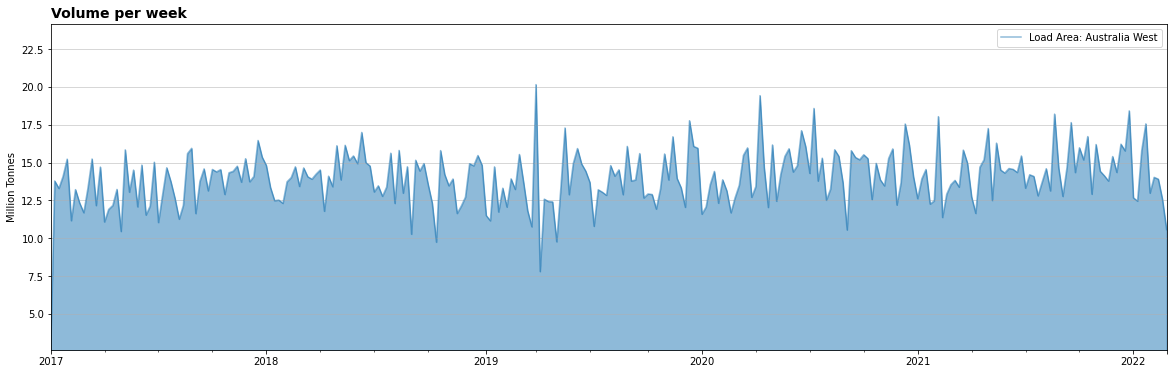

In [21]:
fig, axs = plt.subplots(figsize=(20,6))
volume_per_week.plot(ax=axs, x='first_load_arrival_date', y='deadweight', kind ='area', stacked=False)

# Properties
axs.set_xlabel('')
axs.set_ylabel('Million Tonnes')
axs.set_title('Volume per week',  fontsize=14, fontweight='bold', loc='left',)
axs.legend([f'Load Area: {area_of_interest}'])
axs.set_ylim([min(volume_per_week['deadweight']), 1.2*max(volume_per_week['deadweight'])]);
axs.grid(which='major', axis='y', linewidth=0.5)

### 3.2. Plot: Countries of Destination

The countries of destination plot gives insight to which country the cargo from the specified load area ends up in and in what amount. <br>
To plot it, we need to re-filter the voyages dataframe by date in order to get the date-range of interest. Also, we need to group voyages by discharge country and calculate the percentage of deadweight being imported/exported compared to all the other countries.

First off, specify a new starting date:

In [22]:
date_from = date(2021,1,1) 

Group voyages by countries of destination,

In [23]:
voyages_countries_of_destination = voyages_with_vessels_data.loc[voyages_with_vessels_data['first_load_arrival_date'].dt.date >= date_from].reset_index(drop=True)
voyages_countries_of_destination = voyages_countries_of_destination.groupby(by='discharge_country').sum().reset_index().sort_values('deadweight', ascending=True).reset_index(drop=True)

Compute voyage percentages performing specified activity at each country and append,

In [24]:
voyages_countries_of_destination['%_deadweight'] = 100*voyages_countries_of_destination['deadweight'] / voyages_countries_of_destination['deadweight'].sum()
voyages_countries_of_destination

,discharge_country,deadweight,%_deadweight
0,United Kingdom,180018,0.020558
1,Poland,182644,0.020858
2,United Arab Emirates,206565,0.023589
3,Netherlands,536194,0.061233
4,Philippines,567423,0.064799
5,India,772446,0.088212
6,Malaysia,1460148,0.166747
7,Australia,4099537,0.468162
8,Indonesia,5499493,0.628035
9,Viet Nam,13142833,1.500895


Plot the countries of destination chart as follows:

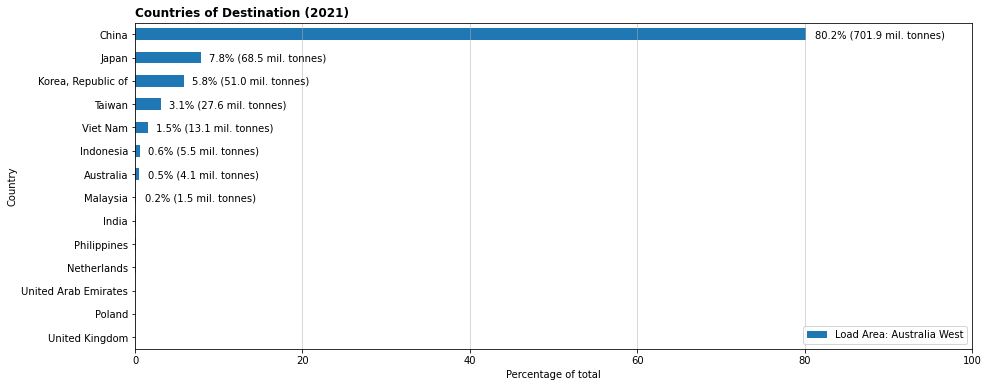

In [25]:
fig, axs = plt.subplots(figsize=(15,6))
voyages_countries_of_destination.plot.barh(ax=axs, y='%_deadweight', x='discharge_country')

# Properties
axs.set_title(f'Countries of Destination ({date_from.year})', loc='left', fontweight='bold')
axs.set_ylabel('Country')
axs.set_xlabel('Percentage of total')
axs.get_legend().remove()
axs.legend([f'Load Area: {area_of_interest}'], loc='lower right')

axs.set_xlim([0, 100])
axs.grid(which='major', axis='x', linewidth=0.5)

for i, v in enumerate(round(voyages_countries_of_destination['%_deadweight'],1)): # attach annotations at end of bars
    if voyages_countries_of_destination['%_deadweight'][i] >= 0.1:
        dwt = voyages_countries_of_destination['deadweight'][i]
        axs.text(v + 1, i - 0.15, f'{v}% ({round(dwt/1e6,1)} mil. tonnes)', color='black')

### 3.3. Plot: Volume Per Month 

The volume per month plot is useful in visualizing how the volume of cargo being transported from/to the specified area changes from year to year on a monthly level.

First, specify how many years back, from the current year, we want to compare and aggregate the voyages deadweight into the respective date-range bins:

In [26]:
years_back = 3

Calculate volume per month,

In [27]:
# Create a new dataframe and aggregate cargo by month and year (multiIndex)
vpm = voyages_with_vessels_data[['first_load_arrival_date', 'deadweight']].set_index('first_load_arrival_date')
volume_per_month = vpm.groupby([vpm.index.month, vpm.index.year]).sum()
volume_per_month.index.rename(['month','year'], inplace=True)

# Filter to last "years_back" years
years = volume_per_month.index.get_level_values('year')
volume_per_month = volume_per_month[years > (date.today().year - years_back)]

volume_per_month['deadweight'] /= 1e6 # in million tonnes
volume_per_month

deadweight
month year            
1     2020   57.249031
      2021   56.302884
      2022   63.608431
2     2020   52.523605
      2021   57.327632
      2022   51.056427
3     2020   63.861629
      2021   63.757555
      2022    4.475667
4     2020   65.196036
      2021   61.424780
5     2020   63.975702
      2021   63.512448
6     2020   66.270437
      2021   63.156756
7     2020   67.050647
      2021   60.493738
8     2020   63.432037
      2021   65.651844
9     2020   61.575203
      2021   65.460524
10    2020   62.859620
      2021   66.903119
11    2020   61.338224
      2021   61.251175
12    2020   67.755055
      2021   71.283506

We can now plot the volume per month chart as follows:

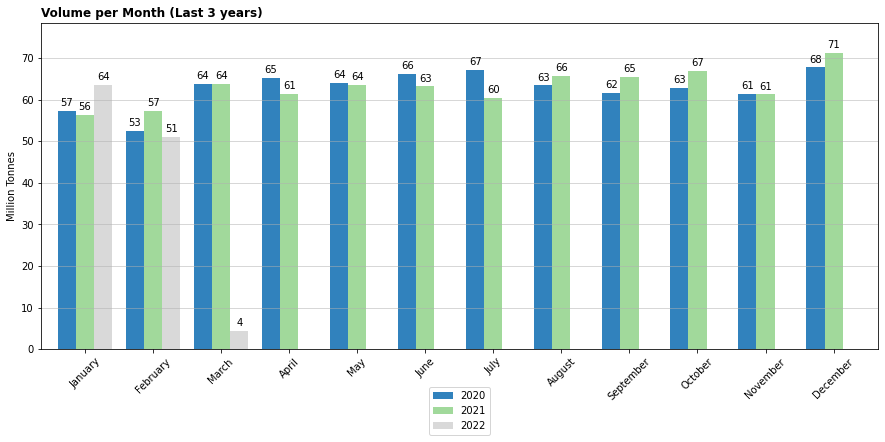

In [28]:
fig, axs = plt.subplots(figsize=(15,6))
volume_per_month.unstack().plot(kind='bar', ax=axs, width=0.8, colormap='tab20c')

years_for_graph = (
    years.unique().sort_values()[-years_back:] if years_back < years.nunique()
    else
    years.unique().sort_values()
)

# Properties
axs.set_title(f'Volume per Month (Last {len(years_for_graph)} years)', loc='left', fontweight='bold')
axs.set_ylabel('Million Tonnes')
axs.set_xlabel('')


axs.legend(years_for_graph, loc='upper center', bbox_to_anchor=(0.5, -0.1))
axs.set_ylim([0, 1.1*max(volume_per_month['deadweight'])])

months = list(map(str, volume_per_month.index.get_level_values('month').array.unique()))
months = [datetime.strftime(datetime.strptime(m, '%m'), '%B') for m in months]
axs.set_xticklabels(months, rotation=45)

axs.grid(which='major', axis='y', linewidth=0.5)

for bar in axs.patches:
    if bar.get_height() > 0:
        axs.annotate(format(bar.get_height(), '0.0f'),
                    (bar.get_x() + bar.get_width()/2,
                     bar.get_height()), ha='center', va='center',
                     size=10, xytext=(0, 8),
                     textcoords='offset points')